In [2]:
import numpy as np
import pandas as pd
import anndata as ad
import stream as st
import matplotlib.pyplot as plt

import os
import sys
import logging

/ocean/projects/cis240075p/asachan/.conda/envs/env_stream/lib/python3.7/site-packages/rpy2/robjects/pandas2ri.py:17: FutureWarning: pandas.core.index is deprecated and will be removed in a future version.  The public classes are available in the top-level namespace.
  from pandas.core.index import Index as PandasIndex


In [2]:
adata_infile = "/ocean/projects/cis240075p/asachan/datasets/B_Cell/multiome_2nd_donor/h5ad_objects/stream_input_filtered_cells.h5ad"
stream_outs_path = '/ocean/projects/cis240075p/asachan/datasets/B_Cell/multiome_2nd_donor/stream_outs/no_rerun_pca'
dictys_data_path = '/ocean/projects/cis240075p/asachan/datasets/B_Cell/multiome_2nd_donor/dictys_outs/data'
stream_obj = os.path.join(stream_outs_path,'stream_traj_no_pca.pkl')

In [3]:
!rsync -aP $stream_obj /dev/shm/

sending incremental file list
stream_traj_no_pca.pkl
  3,018,011,726 100%  362.31MB/s    0:00:07 (xfr#1, to-chk=0/1)


# Run stream dim reduction (LLE) on the anndata, with imputed gene expression and filtered cells

In [5]:
#read the stream result file pkl or h5ad
adata = st.read(file_name='/dev/shm/' + os.path.basename(stream_obj), workdir=stream_outs_path)

Working directory is already specified as '/tmp/tmpu0k7q7sq' 
To change working directory, please run set_workdir(adata,workdir=new_directory)


In [6]:
adata

AnnData object with n_obs × n_vars = 35699 × 3347
    obs: 'gem_well', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'BC1', 'BC2', 'BC3', 'BC4', 'BC5', 'BC6', 'BC7', 'BC8', 'BC9', 'BC10', 'BC11', 'BC12', 'BC13', 'BC14', 'BC15', 'BC16', 'BC17', 'BC18', 'BC19', 'most_likely_hypothesis', 'cluster_feature', 'negative_hypothesis_probability', 'singlet_hypothesis_probability', 'doublet_hypothesis_probability', 'Classification', 'Sample', 'leiden', 'leiden_res_0.10', 'leiden_res_0.25', 'leiden_res_0.50', 'topic_0', 'topic_1', 'topic_2', 'topic_3', 'topic_4', 'topic_5', 'topic_6', 'topic_7', 'topic_8', 'topic_9', 'topic_10', 'topic_11', 'topic_12', 'topic_13', 'topic_14', 'topic_15', 'topic_16', 'topic_17', 'topic_18', 'topic_19', 'topic_20', 'topic_21', 'topic_22', 'topic_23', 'topic_24', 'topic_25', 'topic_26', 'topic_27', 'topic_28', 'topic_29', 'topic_30', 'topic_31', 'topic_32', 'topic_33', 'topic_34', 'topic_35', 'topic_36', 'irf4_prdm1_upDEG', 'irf4

In [7]:
#set the imputed gene expression as the accessible data layer
adata.X = adata.layers['MAGIC_imputed_data']

#### run on all highly_variable imputed genes (4k)

In [28]:
#st.select_variable_genes(adata,loess_frac=0.01,percentile=95)

In [ ]:
# 'var_genes' vs 'all' uses all the imputed, highly variable genes hence make sure the number of vars are only 3k/4k
st.dimension_reduction(adata,method='se',feature='all',n_components=2,n_neighbors=30,n_jobs=64) # using the same knn as diffusion maps (default is 30)

#### Order cell types based on how you think the pseudotime should be

In [7]:
import pandas as pd
adata.obs['leiden'] = pd.Categorical(
    adata.obs['leiden'],
    categories=['ActB-1', 'ActB-2', 'ActB-3', 'earlyPB', 'GC-2', 'GC-1', 'PB-1', 'PB-2'],
    ordered=True
)

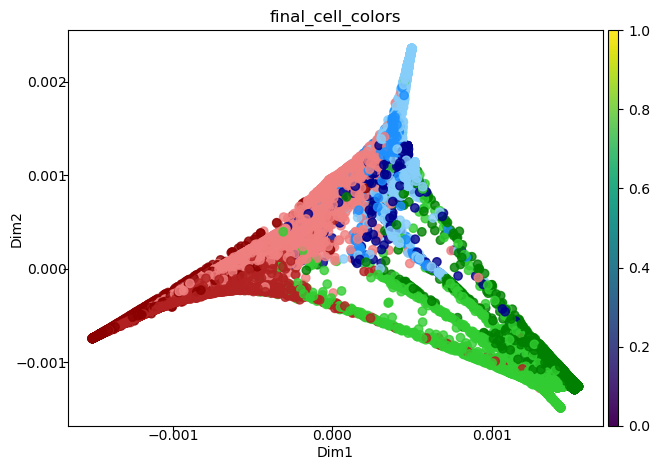

In [8]:
# 2. Store colors in uns with the correct key
leiden_color_dict = {
    'ActB-1': 'lightskyblue',     # light blue cluster
    'ActB-2': 'dodgerblue',       # darker blue cluster
    'ActB-3': 'darkblue',         # dark blue cluster
    'earlyPB': 'lightcoral',      # pink/coral cluster
    'GC-2': 'green',              # darker green cluster
    'GC-1': 'limegreen',          # bright green cluster
    'PB-1': 'firebrick',          # red cluster
    'PB-2': 'darkred'             # darker red cluster
}

# Create a new column in adata.obs for colors
adata.obs['final_cell_colors'] = adata.obs['leiden'].map(leiden_color_dict)

# 3. Try plotting
st.plot_dimension_reduction(adata, color=['final_cell_colors'], n_components=2)

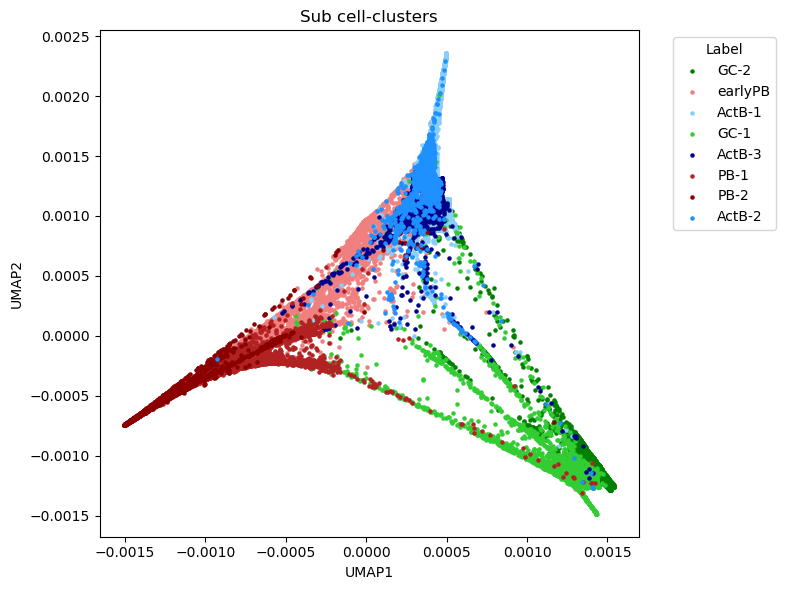

In [9]:
import matplotlib.pyplot as plt
import numpy as np

# Extract UMAP coordinates from the 'X_dr' slot 
umap_coords = adata.obsm['X_dr']

# Extract the labels for coloring
labels = adata.obs['leiden']

# Get unique labels and their corresponding colors
unique_labels = labels.unique()
color_list = [leiden_color_dict[label] for label in unique_labels]

# Plotting the UMAP with colors based on labels
plt.figure(figsize=(8, 6))

for label, color in zip(unique_labels, color_list):
    idx = labels == label
    plt.scatter(umap_coords[idx, 0], umap_coords[idx, 1], c=color, label=label, s=5)  # s=5 sets the marker size to 5 points

plt.title('Sub cell-clusters')
plt.xlabel('UMAP1')
plt.ylabel('UMAP2')
plt.legend(title="Label", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

# Visualize selected cells on the trajectory
### Plot days of cells on trajectory embeddings

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Extract UMAP coordinates from the 'X_dr' slot 
umap_coords = adata.obsm['X_dr']

# Extract the labels for coloring (Day labels)
labels = adata.obs['Sample']

# Get unique labels
unique_labels = labels.unique()

# Define a color for the highlighted cells and for the background cells
highlight_color = '#1f77b4'  # A shade of blue
background_color = '#D3D3D3'  # Light gray

# Create a plot for each unique label
for label in unique_labels:
    plt.figure(figsize=(8, 6))
    
    # Plot background (gray) points first
    plt.scatter(umap_coords[:, 0], umap_coords[:, 1], c=background_color, s=5, alpha=0.5)
    
    # Plot highlighted points
    idx = labels == label
    plt.scatter(umap_coords[idx, 0], umap_coords[idx, 1], c=highlight_color, s=5, label=label)

    plt.title(f'UMAP: {label} cells highlighted')
    plt.xlabel('UMAP1')
    plt.ylabel('UMAP2')
    plt.legend(title="Highlighted Cells", loc='upper left')
    plt.tight_layout()
    plt.show()

## Trajectory inference by fitting elastic graph

In [ ]:
import os
os.environ["OMP_NUM_THREADS"] = "64"
from tempfile import TemporaryDirectory
from rpy2.robjects import r
# Load the rlang package in R
r('library(rlang)')

# Parameters for STREAM (tune to your dataset)
ka1={'epg_alpha':0.02,'epg_mu':0.07,'epg_lambda':0.02,'epg_trimmingradius':2} # epg_mu needs to be tuned to get a good branch for day-1 to activated and undefined cells
ka2={'epg_ext_mode':'QuantDists','epg_ext_par':1.}

# Trajectory inference
with TemporaryDirectory() as td:
	st.set_workdir(adata,td)
	st.seed_elastic_principal_graph(adata,n_clusters=10)
	st.elastic_principal_graph(adata,**ka1)
	st.extend_elastic_principal_graph(adata,**ka2)
	

In [ ]:
st.optimize_branching(adata,incr_n_nodes=30) #smoothen out the branches

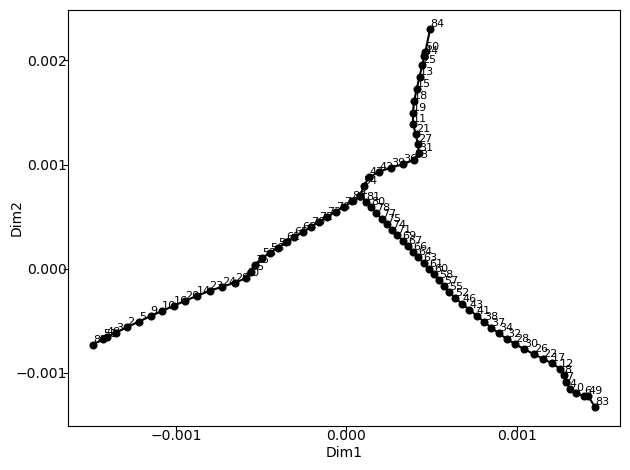

In [6]:
st.plot_branches(adata,show_text=True)

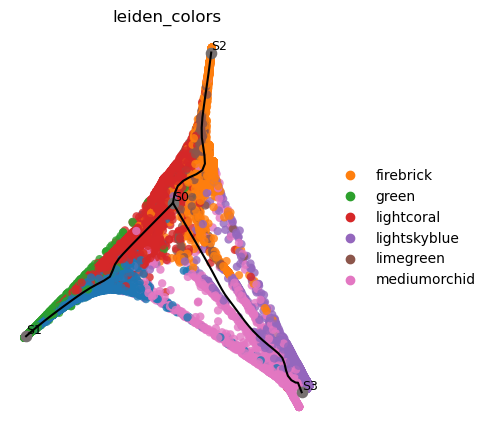

In [7]:
import matplotlib.pyplot as plt

st.plot_dimension_reduction(adata,show_graph=True,show_text=True,color=['leiden_colors'])
ax=plt.gca()
ax.set_aspect(1)
ax.axis('off');


In [ ]:
###Extend leaf branch to reach further cells 
st.extend_elastic_principal_graph(adata, epg_ext_mode='WeigthedCentroid',epg_ext_par=0.8)
st.plot_dimension_reduction(adata,color=['leiden_colors'],n_components=2,show_graph=True,show_text=True)
st.plot_branches(adata,show_text=True)

In [ ]:
#Replace S3 with your own starting node if on a different dataset
st.plot_dimension_reduction(adata,color=['S2_pseudotime','branch_id_alias'])


In [ ]:
st.plot_flat_tree(adata,color=['leiden_colors','S2_pseudotime','branch_id_alias'],
                  dist_scale=0.5,show_graph=True,show_text=True)


### Verifying genes of interest's expression per branch on the trajectory

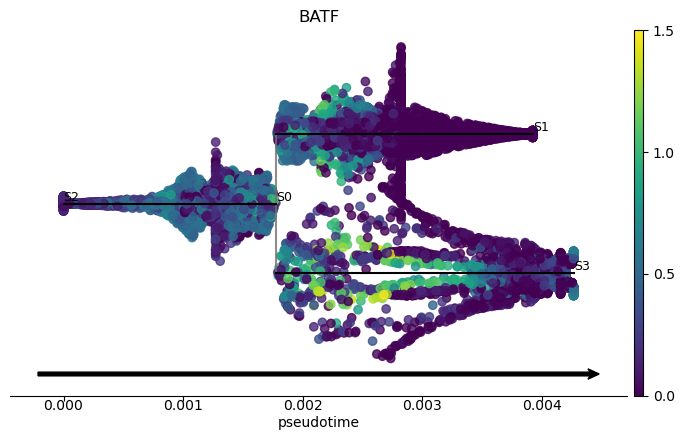

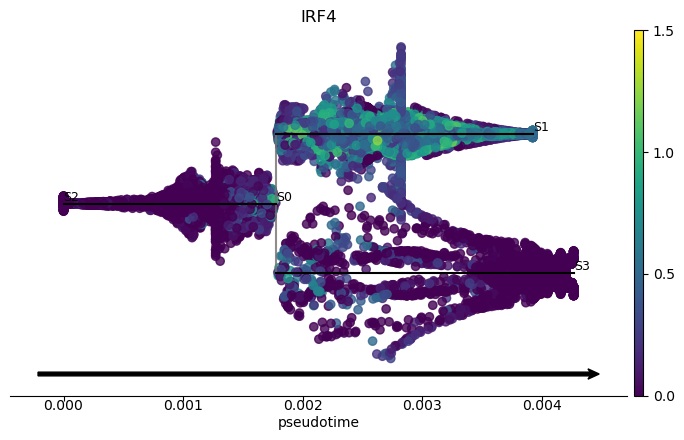

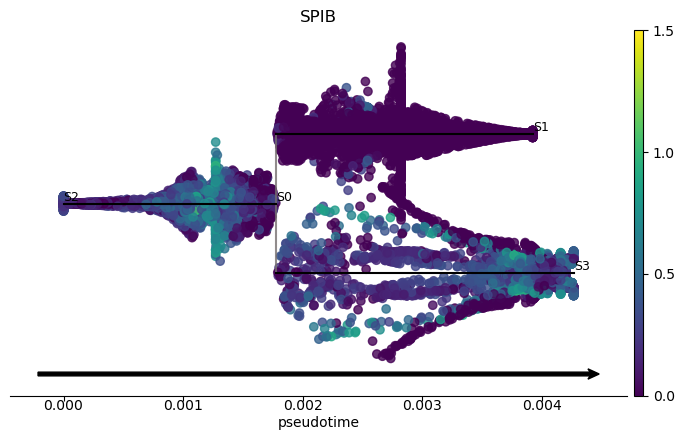

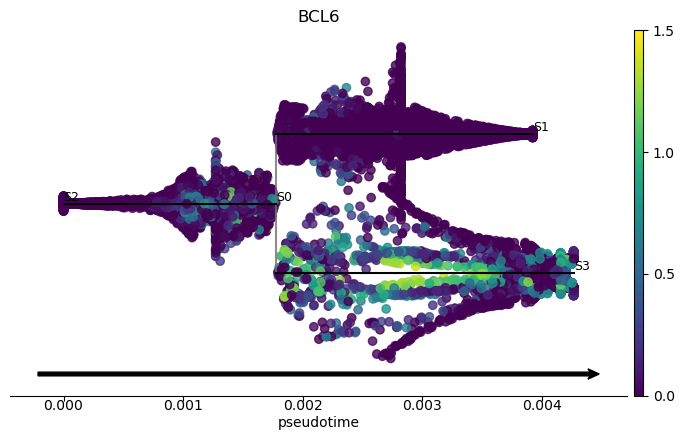

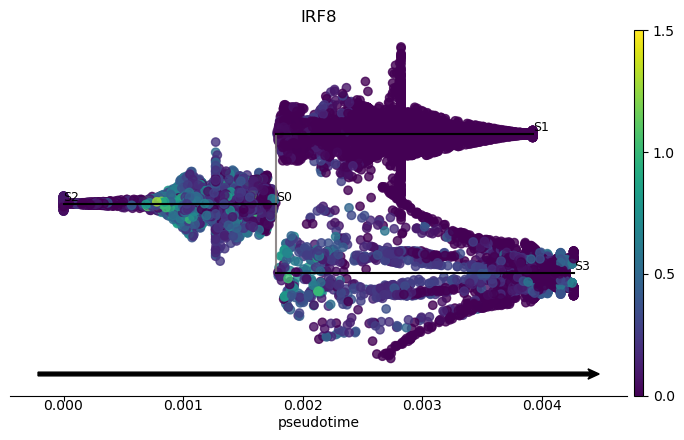

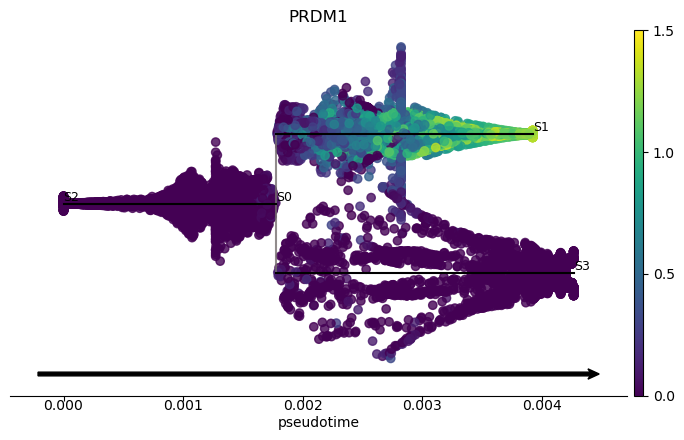

In [8]:
st.plot_stream_sc(adata,root='S2',color=['BATF','IRF4', 'SPIB', 'BCL6', 'IRF8', 'PRDM1'], vmin=0, vmax=1.5,dist_scale=0.3,show_graph=True,show_text=True)

In [6]:
adata.obs.head()

,gem_well,n_genes,n_genes_by_counts,total_counts,total_counts_mt,pct_counts_mt,BC1,BC2,BC3,BC4,...,kmeans,node,branch_id,branch_id_alias,branch_lam,branch_dist,S0_pseudotime,S3_pseudotime,S2_pseudotime,S1_pseudotime
AAACAGCCAAACTAAG-1,gem_1,2954,2954,6554.0,1192.0,14.982403,37.0,4.0,6.0,0.0,...,cluster 0,49,"(83, 1)","(S3, S0)",0.000101,0.000088,0.002387,0.000101,0.004163,0.004533
AAACAGCCAATAATGG-7,gem_7,3091,3091,6220.0,1618.0,20.017320,57.0,5.0,3.0,0.0,...,cluster 8,35,"(85, 1)","(S1, S0)",0.001213,0.000125,0.000932,0.003421,0.002709,0.001213
AAACAGCCAATTGACT-6,gem_6,4358,4358,12847.0,1350.0,9.395226,20.0,3.0,5.0,0.0,...,cluster 9,36,"(84, 1)","(S2, S0)",0.001315,0.000164,0.000461,0.002949,0.001315,0.002607
AAACAGCCACAACAAA-4,gem_4,3626,3626,9638.0,1435.0,12.681159,28.0,10.0,1.0,0.0,...,cluster 9,31,"(84, 1)","(S2, S0)",0.001196,0.000093,0.000580,0.003068,0.001196,0.002726
AAACAGCCACAGACTC-5,gem_5,3365,3365,8009.0,116.0,1.401135,21.0,2.0,7.0,0.0,...,cluster 0,0,"(83, 1)","(S3, S0)",0.000168,0.000041,0.002320,0.000168,0.004097,0.004466


In [7]:
# get max pseudotime for each branch
S1_max_pseudotime = adata.obs['S1_pseudotime'].max()
S2_max_pseudotime = adata.obs['S2_pseudotime'].max()
S3_max_pseudotime = adata.obs['S3_pseudotime'].max()
S0_max_pseudotime = adata.obs['S0_pseudotime'].max()
print(S1_max_pseudotime)
print(S2_max_pseudotime)
print(S3_max_pseudotime)
print(S0_max_pseudotime)


0.004633893213428213
0.00426453936860114
0.004633893213428213
0.0024881978685694964


In [32]:
# save the S2_pseudotime with barcodes (taken from obs.index) to a csv
pseudotime_df = pd.DataFrame({'Barcode': adata.obs.index, 'S2_pseudotime': adata.obs['S2_pseudotime']})
pseudotime_df.to_csv('/ocean/projects/cis240075p/asachan/datasets/B_Cell/multiome_2nd_donor/stream_outs/S2_pseudotime.csv', index=False)


In [10]:
# write stream result to pkl
st.write(adata,file_name='/ocean/projects/cis240075p/asachan/datasets/B_Cell/multiome_2nd_donor/stream_outs/stream_traj_no_pca.pkl')


In [5]:
import numpy as np
import pandas as pd
# Extract node names from pseudotime columns
dimnodes=np.array(sorted([x[:-len('_pseudotime')] for x in adata.obs.columns if x.endswith('_pseudotime')]))
dist=np.array([adata.obs.loc[adata.obs.index,x+'_pseudotime'].values for x in dimnodes]).T
node_dict=dict(zip(dimnodes,range(len(dimnodes))))
branch = np.array([
    sorted([node_dict.get(y.strip('() \''), None) for y in x])
    for x in adata.obs['branch_id_alias']
])

# save the branch, edge, and dist files
stream_outs_path = '/ocean/projects/cis240075p/asachan/datasets/B_Cell/multiome_2nd_donor/stream_outs'
# The branch each cell is on (cell:(node_start,node_end))
branch=pd.DataFrame(branch,index=adata.obs.index)
#branch.to_csv(os.path.join(stream_outs_path,'branch.tsv.gz'),header=False,index=False,sep='\t')

# Identify and save unique edges between nodes
edge=np.unique(branch.values,axis=0)
edge=pd.DataFrame(edge)
display(edge)
#edge.to_csv(os.path.join(stream_outs_path,'edge.tsv.gz'),header=False,index=False,sep='\t')

# The distance of each cell to each node (cell:node, value is pseudotime distance)
dist=pd.DataFrame(dist,index=adata.obs.index,columns=dimnodes)
#dist.to_csv(os.path.join(stream_outs_path,'dist.tsv.gz'),header=True,index=True,sep='\t')


,0,1
0,0,1
1,0,2
2,0,3


#### Make subsets of the sub cell types

In [30]:
dictys_data_path = '/ocean/projects/cis240075p/asachan/datasets/B_Cell/multiome_2nd_donor/dictys_outs/data'
adata.obs.leiden.to_csv(f'{dictys_data_path}/clusters.csv',header=['Cluster'],index=True,index_label='Barcode')


#### Make coord_rna.tsv.gz file of the cells and their lower dim coords, for dictys input

In [ ]:
import anndata as ad
import pandas as pd

# Convert the obs.index (cell barcodes) to a DataFrame
obs_index_df = pd.DataFrame(adata.obs.index)
# Create a new AnnData object with only the cell barcodes and X_dr from obsm
adata_reduced = ad.AnnData(
    obs=obs_index_df,  # Use the cell barcodes as the obs DataFrame
    obsm={"X_dr": adata.obsm['X_dr']}  # Keep only 'X_dr' from obsm
)
# Confirm that the new AnnData object has the correct structure
adata_reduced

In [ ]:
import os
import pandas as pd

# Extract the relevant columns from the AnnData object
# The cell barcodes (obs.index) and 'X_dr' from obsm
cell_barcodes = adata.obs.index
xy_coords = adata_reduced.obsm['X_dr']

# Create a DataFrame with cell barcodes as the first column and 'X_dr' as the next columns
coord_df_b_cell = pd.DataFrame(data=xy_coords, columns=['x', 'y'])
coord_df_b_cell.insert(0, None, cell_barcodes)

#display the df
print(coord_df_b_cell.head())

In [31]:
# Save the DataFrame to a TSV file
output_path = os.path.join(dictys_data_path,'coord_rna.tsv.gz')
coord_df_b_cell.to_csv(output_path, sep='\t', compression='gzip', index=False, header=['', 'x', 'y'])

# Inspecting tut adata (2 branches one) Mouse skin

In [4]:
skin_adata = st.read(file_name='/ocean/projects/cis240075p/asachan/datasets/B_Cell/multiome_1st_donor_UPMC_aggr/tut_files/skin/data/tmp/adata_with_traj.h5ad', workdir='/ocean/projects/cis240075p/asachan/datasets/B_Cell/multiome_1st_donor_UPMC_aggr/tut_files/skin/data/tmp')
skin_adata


Working directory is already specified as '['/tmp/tmppq4_286d']' 
To change working directory, please run set_workdir(adata,workdir=new_directory)


AnnData object with n_obs × n_vars = 6436 × 0
    obs: 'label', 'node', 'branch_id', 'branch_id_alias', 'branch_lam', 'branch_dist', 'S0_pseudotime', 'S2_pseudotime', 'S1_pseudotime', 'S3_pseudotime'
    uns: 'branch_id_alias_color', 'epg', 'epg_obj', 'flat_tree', 'label_color', 'ori_epg', 'ori_epg_obj', 'params', 'workdir'
    obsm: 'X_dr'

In [8]:
skin_adata.uns['epg']

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
       34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50,
       51, 52])

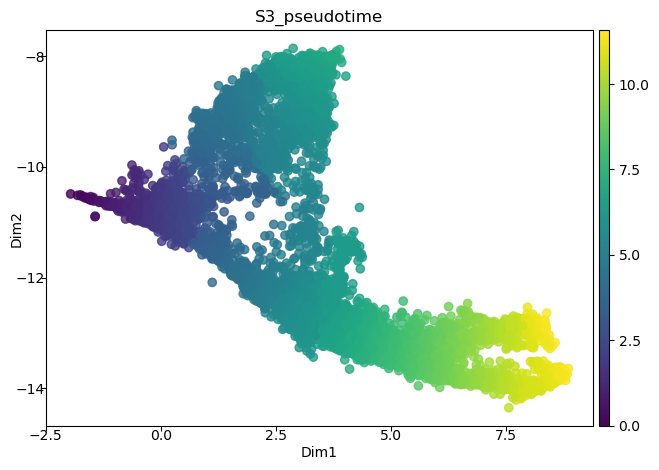

In [6]:
#Only plots ordered categorical data
st.plot_dimension_reduction(skin_adata,color=['S3_pseudotime'])


In [13]:
dictys_data_path = '/ocean/projects/cis240075p/asachan/datasets/B_Cell/multiome_1st_donor_UPMC_aggr/tut_files/skin/data'
skin_adata.obs.label.to_csv(f'{dictys_data_path}/clusters.csv',header=['Cluster'],index=True,index_label='Barcode')


In [3]:
# read in the branch dist and edge files
import pandas as pd
import os
skin_path = '/ocean/projects/cis240075p/asachan/datasets/B_Cell/multiome_1st_donor_UPMC_aggr/tut_files/skin_data/tmp'
branch = pd.read_csv(os.path.join(skin_path,'branch.tsv.gz'),sep='\t',header=None)
edge = pd.read_csv(os.path.join(skin_path,'edge.tsv.gz'),sep='\t',header=None)
dist = pd.read_csv(os.path.join(skin_path,'dist.tsv.gz'),sep='\t',index_col=0)

In [4]:
display(branch.head())
display(edge.head())
display(dist.head())

,0,1
0,0,1
1,0,2
2,0,1
3,0,1
4,0,1


,0,1
0,0,1
1,0,2
2,0,3


,S0,S1,S2,S3
Trial60.skin.R1.01.R2.02.R3.21.P1.56,1.796973,2.377683,10.384121,4.781205
Trial60.skin.R1.01.R2.03.R3.61.P1.54,8.058921,12.233577,0.528227,11.043153
Trial60.skin.R1.01.R2.06.R3.64.P1.56,3.439011,0.735645,12.026159,6.423243
Trial60.skin.R1.01.R2.06.R3.83.P1.55,1.028344,3.146313,9.615491,4.012575
Trial60.skin.R1.01.R2.11.R3.86.P1.56,1.677695,2.496962,10.264842,4.661926
